In [1]:
from platform import python_version
import sys

print(sys.executable)
print(python_version())

/Users/chrispap/.pyenv/versions/3.9.5/bin/python3.9
3.9.5


In [2]:
import numpy as np
import awkward as ak
import uproot
from coffea.nanoevents import NanoEventsFactory, TreeMakerSchema, BaseSchema
from coffea import processor
from coffea.nanoevents.methods import candidate
import matplotlib.pyplot as plt
import mplhep
import hist
from hist import Hist

plt.style.use(mplhep.style.ROOT)
ak.behavior.update(candidate.behavior)

%load_ext line_profiler

In [3]:
def sphericityTensor(particles):
    particles_p = np.sqrt(particles.x * particles.x + particles.y * particles.y + particles.z * particles.z)
    norm = ak.sum(particles_p * particles_p, axis=1)
    s = np.array(
        [
            [
                ak.sum(particles.x * particles.x, axis=1)/norm,
                ak.sum(particles.x * particles.y, axis=1)/norm,
                ak.sum(particles.x * particles.z, axis=1)/norm
            ],
            [
                ak.sum(particles.y * particles.x, axis=1)/norm,
                ak.sum(particles.y * particles.y, axis=1)/norm,
                ak.sum(particles.y * particles.z, axis=1)/norm
            ],
            [
                ak.sum(particles.z * particles.x, axis=1)/norm,
                ak.sum(particles.z * particles.y, axis=1)/norm,
                ak.sum(particles.z * particles.z, axis=1)/norm
            ]
        ]
    )
        
    return s

def sphericity(s):
    s_eigvalues = np.sort(np.linalg.eigvals(np.moveaxis(s, 2, 0)))
    sphericity = 1.5*(s_eigvalues[:,0]+s_eigvalues[:,1])
    return sphericity

In [4]:
baseDir = '/Users/chrispap/QCD/ak15/QCD/'
fname = baseDir + 'Autumn18.QCD_HT1000to1500_TuneCP5_13TeV-madgraphMLM-pythia8_0_RA2AnalysisTree.root'
events = NanoEventsFactory.from_root(fname, 
                                     treepath='TreeMaker2/PreSelection', 
                                     schemaclass=TreeMakerSchema, 
                                     entry_stop=10000).events()

histo = (
     Hist.new
    .Reg(50, 0, 250, name="nTracks")
    .Reg(50, 0, 1, name="sphericity")
    .Weight()
)

integratedLuminosity = 137.19*1000 # fb^{-1} to pb^{-1}
        
ht = events.HT
htRequirement = ht > 1200
weights = integratedLuminosity*events.CrossSection[htRequirement]/len(events)
tracks = events.Tracks[htRequirement]
tracks_pt = np.sqrt(tracks.x**2 + tracks.y**2)
tracks_eta = np.arcsinh(tracks.z / tracks_pt)
tracks_phi = np.arctan2(tracks.y, tracks.x)
tracks_mass = 0.13957*(tracks_pt > 0)
tracks_qualityMask = (tracks_pt > 1) & (abs(tracks_eta) < 2.5) & \
                     (tracks.fromPV0 >= 2) & tracks.matchedToPFCandidate

Make AK15 jets

In [5]:
JetsAK15 = ak.zip(
    {
        "pt": events.JetsAK15.pt,
        "eta": events.JetsAK15.eta,
        "phi": events.JetsAK15.phi,
        "mass": events.JetsAK15.mass,
        "chMult": events.JetsAK15.chargedMultiplicity
    },
    with_name="PtEtaPhiMCandidate",
    behavior=candidate.behavior,
)
JetsAK15 = JetsAK15[htRequirement]
JetsAK15 = JetsAK15[JetsAK15.pt > 200]
JetsAK15 = JetsAK15[:,:2]
suepJets = JetsAK15[ak.argsort(JetsAK15.chMult, ascending=False)][:,0]

In [6]:
JetsAK15.chMult

<Array [[30, 20], [32, 36, ... 38], [29, 50]] type='2777 * var * int32[parameter...'>

In [7]:
suepJets.chMult

<Array [30, 36, 42, 49, 43, ... 61, 62, 59, 50] type='2777 * int32[parameters={"...'>

Get the boost vector

In [8]:
beta = suepJets.pvec/suepJets.energy
beta

<ThreeVectorArray [{x: 0.313, y: -0.933, ... z: 0.384}] type='2777 * ThreeVector...'>

Sanity check

In [9]:
betaMag = np.sqrt(beta.x**2+beta.y**2+beta.z**2)
histBeta = (
     Hist.new
    .Reg(50, 0.5, 1, name="beta")
    .Double()
    .fill(betaMag)
)
histBeta

Hist(Regular(50, 0.5, 1, name='beta', label='beta'), storage=Double()) # Sum: 2777.0

Boost tracks

In [10]:
tracks_final = ak.zip(
    {
        "pt": tracks_pt,
        "eta": tracks_eta,
        "phi": tracks_phi,
        "mass": tracks_mass,
        "charge": tracks.charge
    },
    with_name="PtEtaPhiMCandidate",
    behavior=candidate.behavior,
)
tracks_final = tracks_final[tracks_qualityMask]
#tracks_final = tracks_final[tracks_final.delta_r(suepJets) < 1.5]
#tracks_final = tracks_final.boost(-beta)

# Calculate nTracks
nTracks = ak.sum(tracks_final.pt > 0, axis=1)

Calculate sphericity

In [11]:
sTensor = sphericityTensor(tracks_final)
sph = sphericity(sTensor)

histo.fill(
    nTracks=nTracks,
    sphericity=sph,
    weight=weights
)

s_eigvalues = np.linalg.eigvals(np.moveaxis(sTensor, 2, 0))

In [12]:
%lprun -f sphericity sphericity(sTensor)

In [13]:
s_eigvalues

array([[9.66980612e-01, 1.19869748e-03, 3.18206902e-02],
       [7.55327829e-01, 6.04600306e-03, 2.38626168e-01],
       [8.29076172e-01, 1.47929738e-01, 2.29940897e-02],
       ...,
       [7.71450817e-01, 1.02762771e-01, 1.25786412e-01],
       [9.92410649e-01, 7.11341988e-04, 6.87800913e-03],
       [8.68309930e-01, 6.92312719e-03, 1.24766943e-01]])

In [14]:
np.sort(s_eigvalues)

array([[1.19869748e-03, 3.18206902e-02, 9.66980612e-01],
       [6.04600306e-03, 2.38626168e-01, 7.55327829e-01],
       [2.29940897e-02, 1.47929738e-01, 8.29076172e-01],
       ...,
       [1.02762771e-01, 1.25786412e-01, 7.71450817e-01],
       [7.11341988e-04, 6.87800913e-03, 9.92410649e-01],
       [6.92312719e-03, 1.24766943e-01, 8.68309930e-01]])

In [15]:
ak.sum(tracks_final,axis=1)

<Array [{pt: 401, eta: 1.9, ... charge: 4}] type='2777 * {"pt": float64, "eta": ...'>

In [16]:
deltaR = tracks_final.delta_r(suepJets)
def rho(jet, tracks, deltaR, dr=0.05):
    rho_space = np.linspace(0, 1.5, int(1.5/dr)+1)
    rho_values = []
    for i in range(0, int(1.5/dr)):
        ring = (deltaR > rho_space[i]) & (deltaR < rho_space[i+1])
        if len(rho_values) == 0:
            rho_values = ak.to_numpy(ak.sum(tracks[ring].pt, axis=1)/(dr*jet.pt))
            rho_values = rho_values.reshape(len(rho_values),1)
        else:
            rho_values = np.append(rho_values, ak.to_numpy(ak.sum(tracks[ring].pt, axis=1)/(dr*jet.pt)).reshape(len(rho_values),1),1)
    return rho_values

In [17]:
rho_values = rho(suepJets, tracks_final, deltaR)

In [18]:
deltaR = tracks_final.delta_r(suepJets)

In [19]:
ring = (deltaR > 0.0) & (deltaR < 0.05)
rho_values = ak.sum(tracks_final[ring].pt, axis=1)/(0.05*suepJets.pt)
rho_values

<Array [0.201, 1.09, 6.44, ... 0.0379, 0.14, 0] type='2777 * float64'>

In [20]:
ring[2]

<Array [True, True, False, ... False, False] type='76 * bool'>

In [21]:
histrho = (
     Hist.new
    .Reg(50, 0, 20, name="rho0")
    .Double()
    .fill(rho_values)
)
histrho
#mplhep.histplot(histrho)
#ax = plt.gca()
#ax.set_yscale('log')

Hist(Regular(50, 0, 20, name='rho0', label='rho0'), storage=Double()) # Sum: 2777.0

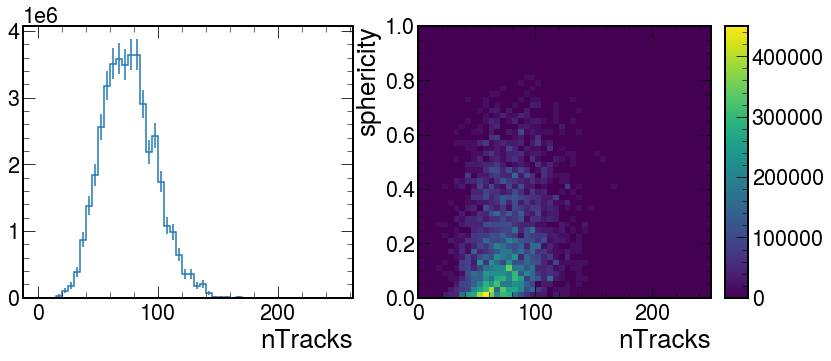

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(13, 5))
mplhep.histplot(histo.project("nTracks"), ax=axs[0])

mplhep.hist2dplot(histo, ax=axs[1])

plt.show()

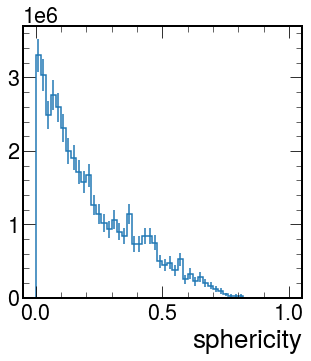

In [23]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
mplhep.histplot(histo.project("sphericity"))

plt.show()

In [49]:
def rho(number, jet, tracks, deltaR, dr=0.05):
    r_start = number*dr
    r_end = (number+1)*dr
    ring = (deltaR > r_start) & (deltaR < r_end)
    rho_values = ak.sum(tracks.pt[ring], axis=1)/(dr*jet.pt)
    return rho_values

%lprun -f rho rho(0, suepJets, tracks_final, deltaR)